In [89]:
from xpbd_softbody import XPBDSoftbody
import pyvista as pv
import config as cfg
import matplotlib.pyplot as plt
import torch
from xpbd_softbody_layer import XPBDStep
import numpy as np
from sklearn.neighbors import KDTree
from xpbd_softbody_layer import get_energy_boundary
from scipy.interpolate import interp1d
from cubic_bezier import *
from tqdm import trange
from torchviz import make_dot

In [90]:
N_skin = 400
N_bandage = 400
control_trajectory = np.array([[0.0099, 0.0014, 0.0013],
                               [0.0079, 0.0014, 0.0033],
                               [0.0059, 0.0014, 0.0053],
                               [0.0039, 0.0014, 0.0057],
                               [0.0019, 0.0014, 0.0063],
                               [-0.0039, 0.0014, 0.0063]])
# control_trajectory = np.array([[-0.4677,  0.0367,  0.1300],
#                                [-0.4677,  0.0367,  0.40],
#                                [-0.4677,  0.0367,  0.60],
#                                [-0.4677,  0.0367,  0.99]])

In [91]:
# interpolate trajectory
x = np.arange(control_trajectory.shape[0])
xnew = np.linspace(x.min(), x.max(), 10 * control_trajectory.shape[0])  # 10 times denser
f = interp1d(x, control_trajectory, axis=0, kind='cubic')
control_trajectory = f(xnew)
control_trajectory = torch.from_numpy(control_trajectory).to(cfg.device)

In [92]:
# load data
softbody = XPBDSoftbody()
skin_mesh = softbody.add_thinshell(pv.Cube(center=(0, 0, 0), x_length=0.02, y_length=0.02, z_length=0.002), n_surf=N_skin)
bandage_mesh = softbody.add_thinshell(pv.Cube(center=(0, 0, 0.002), x_length=0.02, y_length=0.02, z_length=0.002), n_surf=N_bandage)
softbody.init_states()
softbody.init_dist_constraints()
softbody.init_shape_constraints_thinshell([1])
softbody.add_multi_boundary_constrain(1, 0, 0.0025, range(200))
softbody.fix_less_than(0, 0, 2)
softbody.fix_point(1, 50)
# softbody.fix_less_than(1, 0.002, 2)

detect 2 object


In [93]:
# softbody.fix_point(1, 1)

In [94]:
cloth_dist_stiffness = 1
V_boundary_stiffness_ref = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * cloth_dist_stiffness
V_boundary_stiffness = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * V_boundary_stiffness_ref
V_shape_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)*0.0005

In [95]:
filename = 'tissue2tissue_stiffness_' + str(V_boundary_stiffness_ref) + '.gif'
stiffness_text = 'Boundary stiffness = ' + str(V_boundary_stiffness_ref)

In [96]:
softbody.V[450]

tensor([0.0099, 0.0014, 0.0013])

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


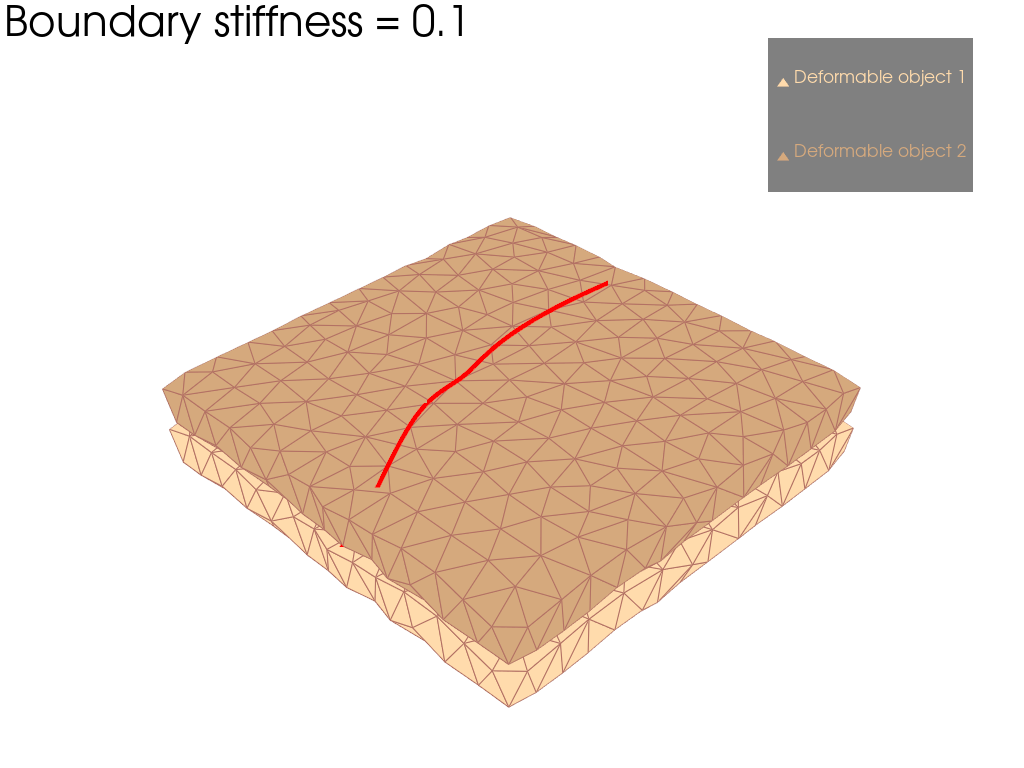

In [97]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
pl.add_lines(control_trajectory.cpu().numpy(), connected=True, color='r')
pl.add_text(stiffness_text)
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'
pl.show()

In [98]:
pl.open_gif(filename)
for i in range(control_trajectory.shape[0]):
    print(i)
    softbody.V[softbody.offset_list[1] + 50] = control_trajectory[i]
    step_ref = XPBDStep(softbody,
                V_dist_stiffness=V_dist_stiffness, 
                V_shape_stiffness=V_shape_stiffness,
                V_boundary_stiffness=V_boundary_stiffness, 
                dt=cfg.dt,
                substep=cfg.substep,
                iteration=cfg.iteration,
                quasi_static=cfg.quasi_static,
                plane_height=cfg.ground_plane_height, 
                use_shape_matching=True,
                use_spring_boundary=True,
                use_dist=True) #cfg.use_spring_boundary
    V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
    softbody.V = V_ref.clone()
    softbody.V_velocity = V_velocity_ref.clone()
    energy = get_energy_boundary(softbody, softbody.V, V_boundary_stiffness)
    # V_boundary_stiffness[energy.squeeze() > 0.5] = 1e-8

    V_boundary_stiffness = V_boundary_stiffness * torch.sigmoid(2e9 * (1e-8 - energy)) + 1e-8 * torch.sigmoid(1e9 * (energy - 1e-8))
    # print(1e-8 * torch.sigmoid(1e9 * (energy - 1e-8)))
    skin_mesh.points = softbody.V[:N_skin].cpu().numpy()
    bandage_mesh.points = softbody.V[N_skin:N_bandage+N_skin].cpu().numpy()
    # pl.remove_actor(bandage_actor)
    # bandage_actor = pl.add_points(softbody.V[N_skin:N_skin+N_bandage].cpu().numpy(), color='r')
    pl.write_frame()
pl.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
